# 04 – Win and Playoff Modeling

Model how pace and efficiency relate to win percentage and playoff probability.

## Goals
- Load team-season aggregates and engineer targets for win percentage and playoff odds.
- Train baseline models (logistic and linear) using pace/efficiency/shot profile features.
- Check feature importances and calibration by era for interpretability.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd

from src.pipeline.season_summary import generate_team_season_summary
from src.data_ingest import NBADataIngestor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    brier_score_loss,
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load regular-season team summaries (use cached CSV when available).
summary_path = Path("data/processed/team_season_regular.csv")
if summary_path.exists():
    summary = pd.read_csv(summary_path)
else:
    ingestor = NBADataIngestor()
    summary = generate_team_season_summary(ingestor, regular_season_only=True, save=False)

summary.head()

,TEAM_ID,SEASON_YEAR,IS_PLAYOFFS,PACE,OFF_EFF_PER_100,DEF_EFF_PER_100,THREE_POINT_RATE,AST_TOV_RATIO,TOTAL_EST_POSSESSIONS,WIN_PCT,GAMES_PLAYED,ERA_KEY,ERA_LABEL,ERA_START_YEAR,ERA_END_YEAR
0,12304,2006,False,75.898936,137.024318,130.436611,0.303797,NaN,75.898936,1.0,1,pace_and_space_rise,Pace-and-Space Rise,2005,2013
1,12321,2012,False,88.874291,109.142925,102.391816,0.269231,1.0,88.874291,1.0,1,pace_and_space_rise,Pace-and-Space Rise,2005,2013
2,12321,2013,False,85.440470,95.973255,111.188527,0.411765,0.8125,85.440470,0.0,1,pace_and_space_rise,Pace-and-Space Rise,2005,2013
3,1610610024,1947,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,pre_shot_clock,Early BAA/NBL,1946,1953
4,1610610029,1948,False,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,pre_shot_clock,Early BAA/NBL,1946,1953


In [3]:
# Basic cleaning and feature selection.
feature_cols = [
    "PACE",
    "OFF_EFF_PER_100",
    "DEF_EFF_PER_100",
    "THREE_POINT_RATE",
    "AST_TOV_RATIO",
]
summary = summary.dropna(subset=feature_cols + ["WIN_PCT"])

# Binary target: top quartile win percentage as proxy for playoff-level success.
win_pct_threshold = summary["WIN_PCT"].quantile(0.75)
summary["TOP_QUARTILE_WIN"] = (summary["WIN_PCT"] >= win_pct_threshold).astype(int)

X = summary[feature_cols]
y_class = summary["TOP_QUARTILE_WIN"]
y_reg = summary["WIN_PCT"]

summary[["WIN_PCT", "TOP_QUARTILE_WIN"] + feature_cols].describe(include="all")

,WIN_PCT,TOP_QUARTILE_WIN,PACE,OFF_EFF_PER_100,DEF_EFF_PER_100,THREE_POINT_RATE,AST_TOV_RATIO
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,179.0
top,NaN,NaN,NaN,NaN,NaN,NaN,1.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,11.0
mean,0.492218,0.482490,103.499465,108.276925,108.427557,0.222597,NaN
std,0.496017,0.500668,14.095664,12.973109,12.992439,0.138811,NaN
min,0.000000,0.000000,81.655197,70.459581,70.459581,0.000000,NaN
25%,0.000000,0.000000,93.448469,98.449981,98.779271,0.121212,NaN
50%,0.500000,0.000000,99.193208,108.041123,107.574059,0.206612,NaN
75%,1.000000,1.000000,113.410242,117.182585,117.182585,0.291139,NaN


ROC AUC: 0.9881481481481482
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        27
           1       0.96      0.96      0.96        25

    accuracy                           0.96        52
   macro avg       0.96      0.96      0.96        52
weighted avg       0.96      0.96      0.96        52



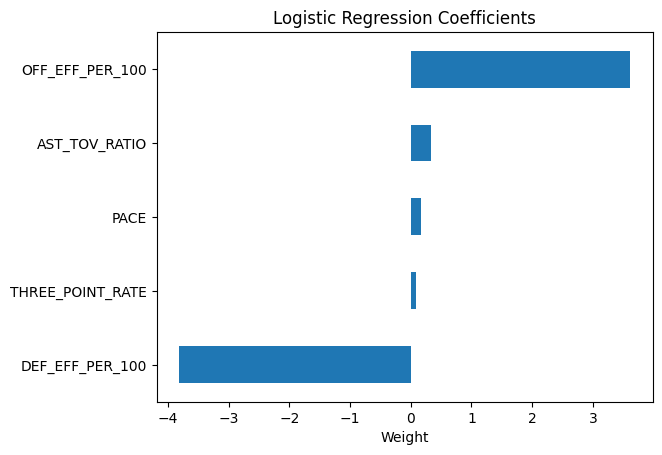

In [4]:
# Classification: logistic regression on standardized features.
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

log_clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=500, penalty="l2", solver="lbfgs"),
)
log_clf.fit(X_train, y_train)

probs = log_clf.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, probs))
print(classification_report(y_test, preds))

# Extract feature weights for interpretation.
coef = log_clf.named_steps["logisticregression"].coef_.ravel()
importance = pd.Series(coef, index=feature_cols).sort_values()
importance.plot(kind="barh", title="Logistic Regression Coefficients")
plt.xlabel("Weight")
plt.show()

In [5]:
# Regression: predict win percentage directly.
reg_model = make_pipeline(StandardScaler(), LinearRegression())
reg_model.fit(X, y_reg)
pred_win_pct = reg_model.predict(X)

rmse = np.sqrt(mean_squared_error(y_reg, pred_win_pct))
print(f"RMSE on full sample: {rmse:.4f}")

residuals = y_reg - pred_win_pct
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title("Residual distribution")
sns.scatterplot(x=pred_win_pct, y=residuals, ax=ax[1])
ax[1].axhline(0, color="red", linestyle="--")
ax[1].set_xlabel("Predicted WIN_PCT")
ax[1].set_ylabel("Residual")
ax[1].set_title("Residuals vs Predictions")
plt.tight_layout()
plt.show()

TypeError: got an unexpected keyword argument 'squared'

### Model zoo and report-ready metrics
Compare multiple classifiers on the top-quartile playoff proxy and capture headline metrics for the report.

In [ ]:
# Classification model zoo.
class_models = {
    "LogReg": make_pipeline(StandardScaler(), LogisticRegression(max_iter=600, penalty="l2", solver="lbfgs")),
    "SVC-linear": make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True, random_state=42)),
    "RandomForest": RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=2, random_state=42),
    "GradBoost": GradientBoostingClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=15)),
}

class_records = []
for name, model in class_models.items():
    model.fit(X_train, y_train)
    probas = model.predict_proba(X_test)[:, 1]
    preds = (probas >= 0.5).astype(int)
    class_records.append(
        {
            "model": name,
            "roc_auc": roc_auc_score(y_test, probas),
            "accuracy": accuracy_score(y_test, preds),
            "f1": f1_score(y_test, preds),
        }
    )

class_df = pd.DataFrame(class_records).sort_values("roc_auc", ascending=False)
class_df


In [ ]:
# Confusion matrix for the top-performing classifier.
best_model_name = class_df.iloc[0]["model"]
best_model = class_models[best_model_name]
best_preds = best_model.predict(X_test)
cm = confusion_matrix(y_test, best_preds)
print(f"Best classifier: {best_model_name}")
print(cm)


### Calibration (regular-season best classifier)
Reliability curve and Brier score for the top model to report probability quality.

In [ ]:
probs_best = best_model.predict_proba(X_test)[:, 1]
brier = brier_score_loss(y_test, probs_best)
prob_true, prob_pred = calibration_curve(y_test, probs_best, n_bins=10, strategy="quantile")

print(f"Brier score (lower is better): {brier:.4f}")
plt.figure(figsize=(5, 5))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve")
plt.legend()
plt.show()

### Regression baselines
Benchmark RMSE/MAE/R² for predicting win percentage.

In [ ]:
reg_models = {
    "Linear": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, min_samples_leaf=2),
    "GradBoost": GradientBoostingRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(max_depth=8, random_state=42),
    "KNN": make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=15)),
}

reg_records = []
for name, model in reg_models.items():
    model.fit(X, y_reg)
    preds = model.predict(X)
    reg_records.append(
        {
            "model": name,
            "rmse": np.sqrt(mean_squared_error(y_reg, preds)),
            "mae": mean_absolute_error(y_reg, preds),
            "r2": r2_score(y_reg, preds),
        }
    )

reg_df = pd.DataFrame(reg_records).sort_values("rmse")
reg_df


### Feature ablations
Remove one feature at a time to quantify its contribution to classification AUC and regression RMSE.

In [ ]:
def evaluate_ablation(drop_cols):
    cols = [c for c in feature_cols if c not in drop_cols]
    X_sub = summary[cols].dropna()
    y_class_sub = summary.loc[X_sub.index, "TOP_QUARTILE_WIN"]
    y_reg_sub = summary.loc[X_sub.index, "WIN_PCT"]
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_sub, y_class_sub, test_size=0.2, random_state=42, stratify=y_class_sub
    )
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=600))
    clf.fit(X_train_sub, y_train_sub)
    probas = clf.predict_proba(X_test_sub)[:, 1]
    auc = roc_auc_score(y_test_sub, probas)

    reg = make_pipeline(StandardScaler(), LinearRegression())
    reg.fit(X_sub, y_reg_sub)
    rmse = np.sqrt(mean_squared_error(y_reg_sub, reg.predict(X_sub)))
    return auc, rmse

ablation_records = []
for col in feature_cols:
    auc, rmse = evaluate_ablation([col])
    ablation_records.append({"dropped": col, "auc_no_feat": auc, "rmse_no_feat": rmse})

ablation_df = pd.DataFrame(ablation_records).sort_values("auc_no_feat", ascending=False)
ablation_df


These tables can drop straight into the LaTeX report (classification AUC/accuracy/F1, regression RMSE/MAE/R², and ablation deltas).

### Playoff-only evaluation
Re-run the classification zoo on playoff team-seasons to capture postseason alignment.

In [ ]:
playoff_path = Path("data/processed/team_season_playoffs.csv")
if playoff_path.exists():
    playoff = pd.read_csv(playoff_path)
else:
    ingestor = NBADataIngestor()
    playoff = generate_team_season_summary(ingestor, playoffs_only=True, save=False)

playoff = playoff.dropna(subset=feature_cols + ["WIN_PCT"])
if len(playoff) < 20:
    print(f"Playoff sample too small for robust eval (n={len(playoff)}).")
else:
    playoff_threshold = playoff["WIN_PCT"].quantile(0.75)
    playoff["TOP_QUARTILE_WIN"] = (playoff["WIN_PCT"] >= playoff_threshold).astype(int)
    X_po = playoff[feature_cols]
    y_po = playoff["TOP_QUARTILE_WIN"]
    X_train_po, X_test_po, y_train_po, y_test_po = train_test_split(
        X_po, y_po, test_size=0.2, random_state=42, stratify=y_po
    )

    po_records = []
    for name, model in class_models.items():
        model.fit(X_train_po, y_train_po)
        probas_po = model.predict_proba(X_test_po)[:, 1]
        preds_po = (probas_po >= 0.5).astype(int)
        po_records.append(
            {
                "model": name,
                "roc_auc": roc_auc_score(y_test_po, probas_po),
                "accuracy": accuracy_score(y_test_po, preds_po),
                "f1": f1_score(y_test_po, preds_po),
            }
        )
    playoff_df = pd.DataFrame(po_records).sort_values("roc_auc", ascending=False)
    playoff_df


## Next Steps
- Add era-stratified splits or time-based CV to test stability of coefficients.
- Calibrate classifiers (Platt/Isotonic) and compare lift vs uncalibrated.
- Add playoff-only split and compare deltas against regular-season models.